In [2]:
import panel as pn

pn.extension('tabulator', sizing_mode = 'stretch_width')

#import hvplot.pandas
import holoviews as hv
import pandas as pd
import numpy as np
import hvplot.pandas

hv.extension('bokeh')

import os 

cwd = os.getcwd()

#relacion entre regiones, cuencas y subcuencas DGA
path = os.path.join(cwd,'Data', 'Excel','reg_cuen_sc.xlsx')
hid = pd.read_excel(path)

#raw data caudales
path = os.path.join(cwd,'Data', 'Excel','q_est.pkl')
q = pd.read_pickle(path)
path = os.path.join(cwd,'Data', 'Excel','q_mon_1950-2022-full.pkl')
q_mon = pd.read_pickle(path)

dummy_df = pd.DataFrame(columns=['Q [m3/s]'])

q['Q [m3/s]']=""
q.reset_index(inplace=True)
q.rename(columns={'index':'fecha'}, inplace = True)
q['date'] = q['fecha'].apply(lambda x: x.date())
q.set_index('date', inplace = True)


#pd.concat((q_mon,dummy_df),axis=1)
q_mon['Q [m3/s]']=""
q_mon =q_mon.reset_index()
q_mon = q_mon.rename(columns={'index':'fecha'})
q_mon['date'] = q_mon['fecha'].apply(lambda x: x.date())
q_mon.set_index('date', inplace = True)


#metadata estaciones
path = os.path.join(cwd,'Data', 'Excel','gdf_est.xlsx')
md_est = pd.read_excel(path)


#crear columna con nombre estacion - rut
md_est['codigo'] = md_est['Estacion'] + ' (' +md_est['rut'] + ')'


def select(reg, cue, df):
    
    if reg == 'Todas' and cue=='Todas':
        n=len(df)
        return [True]*n
    elif reg =='Todas' and cue!= 'Todas':
    
        return df['NOM_CUEN']==cue
    elif reg !='Todas' and cue=='Todas':
        return df['Region']==reg
    else:
        return (df['NOM_CUEN']==cue)*(df['Region']==reg)
    
    
def sublist(event):
    
    #funcion que devuelve nueva lista de cuencas y subcuemcas
    region = select_r.value
    
    lista_cuencas= ['Todas']+ sorted(hid['NOM_CUEN'][(select(region,'Todas',hid))].unique().tolist())
    select_c.options = lista_cuencas
    
    lista_subcuencas = ['Todas']+ sorted(hid['NOM_SUBC'][(select(region,select_c.value,hid))].unique().tolist())        
    select_sc.options = lista_subcuencas
  

    
def sel_est(event):
    fil1 = pd.Series([True]*len(md_est))
    fil2 =  pd.Series([True]*len(md_est))
    fil3 =  pd.Series([True]*len(md_est))
    sc = select_sc.value
    cue = select_c.value
    reg = select_r.value
        
    if sc!= 'Todas':
        fil1 = md_est['NOM_SUBC']==sc
    if cue!= 'Todas':
        fil2 = md_est['Cuenca']==cue
    if reg != 'Todas':
        fil3 = md_est['REGION']==reg
        
    df_filt = md_est[fil1 & fil2 & fil3]['codigo'] 
    
    if (reg =='Todas') and (cue == 'Todas') and (sc=='Todas'):
        df_filt = md_est['codigo']
    
    lista_estaciones = ['Seleccione una estación']+ (sorted(df_filt))

    if len(lista_estaciones) ==1: #solo existe el elemento selecione una estacion
        lista_estaciones = ['No existen estaciones disponibles']
    
    select_est.options = lista_estaciones


def reset(event):
    select_r.value = 'Todas'
    select_c.value = 'Todas'
    select_sc.value = 'Todas'
    select_est.value = 'Seleccione una estación'
    



def web_mercator(df, lon= "Lon", lat="Lat"):
    #Convert dec lon/lat to Web Mercator format
    k = 6378137
    df["x"] = df["Lon"] * (k*np.pi/180.0)
    df["y"] = np.log(np.tan((90+df["Lat"])*np.pi / 360 ))*k
    return df

def boundary_change(event):

    if select_est.value != 'Seleccione una estación' and select_est.value != 'No existen estaciones disponibles' :
        plot.x_range.end = (md_est[md_est["codigo"]==select_est.value]['x']).item()+1000
        plot.x_range.start = (md_est[md_est["codigo"]==select_est.value]['x']).item()-1000
        plot.y_range.end = (md_est[md_est["codigo"]==select_est.value]['y']).item()+1000
        plot.y_range.start = (md_est[md_est["codigo"]==select_est.value]['y']).item()-1000
        
    elif select_sc.value != 'Todas':
        temp = str(hid[hid['NOM_SUBC']==select_sc.value]['COD_SUBC'].iloc[0])
        if len(temp) < 4:
            cod_subc = '0'+str(hid[hid['NOM_SUBC']==select_sc.value]['COD_SUBC'].iloc[0])
        else:
            cod_subc = temp
        geo_subc = gdf_sc[gdf_sc['COD_SUBC']==cod_subc].geometry.bounds

        plot.x_range.end = max(geo_subc['maxx'])
        plot.x_range.start = min(geo_subc['minx'])
        plot.y_range.end = max(geo_subc['maxy'])
        plot.y_range.start = min(geo_subc['miny'])
    
    elif select_c.value != 'Todas':
    
        temp = str(hid[hid['NOM_CUEN']==select_c.value]['COD_CUEN'].iloc[0])
        
        if len(temp) < 3:    
            cod_c = '0'+str(hid[hid['NOM_CUEN']==select_c.value]['COD_CUEN'].iloc[0])
            
        else:
            cod_c = temp
        geo_c = gdf_cuencas[gdf_cuencas['COD_CUEN']==cod_c].geometry.bounds
        
        plot.x_range.end = max(geo_c['maxx'])
        
        plot.x_range.start = min(geo_c['minx'])
        plot.y_range.end = max(geo_c['maxy'])
        plot.y_range.start = min(geo_c['miny'])
        
    elif select_r.value != 'Todas':        
        geo_r = df_reg[df_reg['Region']==select_r.value].geometry.bounds

        plot.x_range.end = max(geo_r['maxx'])
        plot.x_range.start = min(geo_r['minx'])
        plot.y_range.end = max(geo_r['maxy'])
        plot.y_range.start = min(geo_r['miny'])  
    else:
        plot.x_range.end = max(md_est['x'])
        plot.x_range.start = min(md_est['x'])
        plot.y_range.end = max(md_est['y'])
        plot.y_range.start = min(md_est['y'])
        
    plot.output_backend = "webgl"
    plot.match_aspect = True

def update_dict(*events):
    
    for event in events:
        if event.new == 'Diaria':
            source_dict['agregacion'] = 'Diaria'
           
        elif event.new == 'Mensual':
            source_dict['agregacion'] = 'Mensual'
        else:
            source_dict['estacion'] = event.new
    
    
md_est=web_mercator(md_est)


C:\Users\rcbso\AppData\Local\Temp\ipykernel_3652\2765709891.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  q_mon['Q [m3/s]']=""


In [2]:
#Dictionary to save selected values, it updates with the widgets
source_dict = {
    'estacion': 'Seleccione una estación',
    'agregacion' : 'Diaria'
}


PNG(str, sizing_mode='stretch_width')
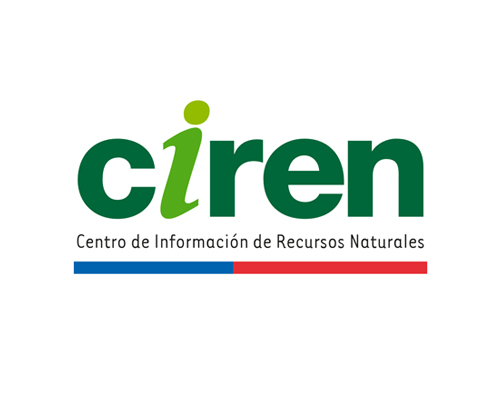

In [17]:
#logo CIREN
path_img = os.path.join(cwd,'Data', 'img', 'logo.png')
png_pane = pn.pane.PNG(path_img, width = 300)


In [3]:
#Selectores
lista_reg = ['Todas'] + list(hid['Region'].unique())
lista_cuencas = ['Todas']+ sorted(hid['NOM_CUEN'].unique().tolist())
lista_subcuencas = ['Todas']+ sorted(hid['NOM_SUBC'].unique().tolist())
lista_estaciones = ['Seleccione una estación']+list(sorted(md_est['codigo']))


select_r= pn.widgets.Select(name='Seleccione una región', options=lista_reg)
select_c= pn.widgets.Select(name='Seleccione una cuenca', options=lista_cuencas)
select_sc= pn.widgets.Select(name='Seleccione una subcuenca', options=lista_subcuencas)
select_est= pn.widgets.Select(name='Seleccione una estación', options=lista_estaciones)

select_r.param.watch(sublist, 'value')
select_c.param.watch(sublist, 'value')
#select_sc.param.watch(sublist, 'value')

select_r.param.watch(sel_est, 'value')
select_c.param.watch(sel_est, 'value')
select_sc.param.watch(sel_est, 'value')
select_est.param.watch(sel_est, 'value')

select_r.param.watch(boundary_change, 'value')
select_c.param.watch(boundary_change, 'value')
select_sc.param.watch(boundary_change, 'value')
select_est.param.watch(boundary_change, 'value')


select_est.param.watch(update_dict, 'value')

Watcher(inst=Select(name='Seleccione una estación', options=['Seleccione una estación'...], sizing_mode='stretch_width', value='Seleccione una estación'), cls=<class 'panel.widgets.select.Select'>, fn=<function update_dict at 0x000001C833C0FAC0>, mode='args', onlychanged=True, parameter_names=('value',), what='value', queued=False, precedence=0)

In [4]:
#Boton de reset

reset_button = pn.widgets.Button(name = 'Borrar Selección', button_type = 'primary')
reset_button.margin = [20,0,20,0]
reset_button.on_click(reset)
    

Watcher(inst=Button(button_type='primary', margin=[20, 0, 20, 0], name='Borrar Selección', sizing_mode='stretch_width'), cls=<class 'panel.widgets.button.Button'>, fn=<function reset at 0x000001C833C0F640>, mode='args', onlychanged=False, parameter_names=('clicks',), what='value', queued=False, precedence=0)

In [5]:
#mapa

import geopandas as gpd
from bokeh.plotting import figure
from bokeh.tile_providers import CARTODBPOSITRON, get_provider
from bokeh.models import  ResetTool, PanTool, WheelZoomTool, ColumnDataSource, GeoJSONDataSource, HoverTool, TapTool

def web_mercator(df, lon= "Lon", lat="Lat"):
        #Convert dec lon/lat to Web Mercator format
        k = 6378137
        df["x"] = df["Lon"] * (k*np.pi/180.0)
        df["y"] = np.log(np.tan((90+df["Lat"])*np.pi / 360 ))*k
        return df


#plot data
# # cargar data de regiones, pero no plotearla

path = os.path.join(cwd,'Data', 'Shapefiles','Regional.shp')
df_reg = gpd.read_file(path).to_crs('EPSG:3857')

path = os.path.join(cwd,'Data', 'Shapefiles','Cuencas_BNA_lat.shp')
gdf_cuencas = gpd.read_file(path).to_crs('EPSG:3857')

path = os.path.join(cwd,'Data', 'Shapefiles','Subcuencas_BNA_lat.shp')
gdf_sc = gpd.read_file(path).to_crs('EPSG:3857')

md_est=web_mercator(md_est)

tile_provider = get_provider('STAMEN_TERRAIN') # CARTODBPOSITRON, get_provider, ESRI_IMAGERY, STAMEN_TERRAIN


# Create the plot
plot = figure(tools = '',
              x_range=(min(md_est['x']), max(md_est['x'])), 
              y_range=(min(md_est['y']),max(md_est['y'])),
              x_axis_type="mercator", y_axis_type="mercator",
              match_aspect = True, output_backend="webgl")

geosource2 = GeoJSONDataSource(geojson = gdf_cuencas.to_json())
cuencas = plot.patches('xs', 'ys', source = geosource2,
                    fill_color = None,
                    line_color = 'black',
                    line_width = 1.0,
                    visible=False)

geosource3 = GeoJSONDataSource(geojson = gdf_sc.to_json())
subcuencas = plot.patches('xs', 'ys', source = geosource3,
                    fill_color = 'green',
                    line_color = 'darkgreen',
                    line_width = 1.0,
                    fill_alpha = 0.5,
                    visible=False)

#-------- Make the ColumnDataSource: source
source = ColumnDataSource(data={
    'x'       : md_est["x"],
    'y'       : md_est["y"],
    'Estacion': md_est["Estacion"],
    'Rut' : md_est["rut"],
})

estaciones = plot.circle(x='x', y='y', fill_alpha=1, color = 'magenta', size =5, source=source)  
 #-------- add Hover Tool
hover = HoverTool(tooltips = [('Nombre', '@Estacion')
                               ], renderers=[estaciones])
plot.add_tools(hover)

plot.add_tile(tile_provider, name ='basemap')

#-------- add WheelZoomTool
zoom = WheelZoomTool()
plot.add_tools(zoom)

#-------- add Reset Tool
reset = ResetTool()
plot.add_tools(reset)
#--------

#-------- add Pan Tool
pan = PanTool()
plot.add_tools(pan)


#--------  Define the CheckboxGroup widget
from bokeh.models import  CheckboxGroup

checkbox_group = CheckboxGroup(labels=['Cuencas', 'Subcuencas' , 'Estaciones'], 
                               active=[2], 
                               inline=True)
                    
#--------  Define a callback function to control the visibility of the layers
def update_layers(attr, old, new):
    for i in old:
        plot.renderers[i].visible = False
    for i in new:
        plot.renderers[i].visible = True

checkbox_group.on_change('active', update_layers)

#------- add Tap Tool
indice = []  
    
def tap_index(attr, old, new):
    indice = source.selected.indices
    
    if indice: #si existe algo seleccionado se tomara el primer elemento
        estacion = md_est.loc[indice[0]].codigo
        select_est.value = estacion
        select_r.value =md_est[md_est['codigo']==estacion]['REGION'].iloc[0]
        select_c.value = md_est.loc[indice[0]].Cuenca
        select_sc.value =md_est[md_est['codigo']==estacion]['NOM_SUBC'].iloc[0]



tap = TapTool(renderers=[estaciones])
plot.add_tools(tap)
source.selected.on_change("indices", tap_index)



In [6]:
#Display information of selected estation

html_pane = pn.pane.HTML("<h3> Información estación </h3>",style={'background-color': '#F6F6F6',  'padding': '10px'})

def show_info(event):

    ## Crear HTML si es que hay algo seleccionado
    if select_est.value != 'Seleccione una estación' and select_est.value != 'No existen estaciones disponibles' :
        
        data_est = md_est[md_est['codigo']==select_est.value].reset_index()
        nombre = data_est.Estacion.iloc[0]
        rut = data_est.rut.iloc[0]
        coordenadas = "(" + str(md_est.Este.iloc[0])+ " m.E, " +str(md_est.Norte.iloc[0]) + " m.N)"
        #### revisar como se puede obtener el estado de la estacion
        region = data_est.REGION.iloc[0]
        cuenca = data_est.Cuenca.iloc[0]
        subcuenca = data_est.Subcuenca.iloc[0]
        
        html =   f"""
        
        <style type="text/css">
        .tg  {{border-collapse:collapse;border-spacing:0;}}
        .tg td{{border-color:black;border-style:solid;border-width:1px;font-size:14px;
          overflow:hidden;padding:10px 5px;word-break:normal;}}
        </style>
        
        <h3> Información estación </h3>
        <table class="tg" >
            <thead>
              <tr>
                <td class="tg-0lax">Estación:</th>
                <td class="tg-0lax">{nombre}</th>
              </tr>
            </thead>
            <tbody>
              <tr>
                <td class="tg-0lax">Rut:</td>
                <td class="tg-0lax">{rut}</td>
              </tr>
              <tr>
                <td class="tg-0lax">Región:</td>
                <td class="tg-0lax">{region}</td>
              </tr>
              <tr>
                <td class="tg-0lax">Cuenca:</td>
                <td class="tg-0lax">{cuenca}</td>
              </tr>
              <tr>
                <td class="tg-0lax">Subcuenca:</td>
                <td class="tg-0lax">{subcuenca}</td>
              </tr>
            </tbody>
            </table> 
                     """
    else:
        html = ""
        
    html_pane.object = html
        
        
        
select_est.param.watch(show_info, 'value')

Watcher(inst=Select(name='Seleccione una estación', options=['Seleccione una estación'...], sizing_mode='stretch_width', value='Seleccione una estación'), cls=<class 'panel.widgets.select.Select'>, fn=<function show_info at 0x000001C8002C9000>, mode='args', onlychanged=True, parameter_names=('value',), what='value', queued=False, precedence=0)

In [7]:
#Agracion temporal de data
radio_group = pn.widgets.RadioButtonGroup(
    name='Agregación temporal data', options=['Diaria', 'Mensual'])
radio_group.margin = [20,0,20,0]

radio_group.param.watch(update_dict, 'value')


Watcher(inst=RadioButtonGroup(margin=[20, 0, 20, 0], name='Agregación temporal d..., options=['Diaria', 'Mensual'], sizing_mode='stretch_width', value='Diaria'), cls=<class 'panel.widgets.select.RadioButtonGroup'>, fn=<function update_dict at 0x000001C833C0FAC0>, mode='args', onlychanged=True, parameter_names=('value',), what='value', queued=False, precedence=0)

In [8]:
# Data plot of selected station

#param to init the chart

df_q = q[['Q [m3/s]','fecha']]
line_plot = df_q.hvplot.line(x='fecha', y='Q [m3/s]',line_width=1.50, color = 'navy', height=500, width=700)
line_plot.opts(ylim =(0,10))
first_date_init = df_q.index[0]
last_date_init = df_q.index[-1]
date_picker_start = pn.widgets.DatePicker(name='Fecha inicio', value=first_date_init, start = first_date_init, end =last_date_init)
date_picker_end = pn.widgets.DatePicker(name='Fecha término' , value=last_date_init, start = first_date_init, end =last_date_init)

def star_end_date(event):
    estacion = select_est.value
    global df_q
    if estacion!= 'Seleccione una estación' and estacion != 'No existen estaciones disponibles' : 
        data_est = md_est[md_est['codigo']==estacion].reset_index()
        rut = data_est.rut.iloc[0] 
        df_q = q[[rut, 'fecha']]
        first_date=df_q[rut].first_valid_index()
        last_date =df_q[rut].last_valid_index()
    else:
        first_date = first_date_init
        last_date = last_date_init
       
    date_picker_start.start = first_date
    date_picker_start.end = last_date
    date_picker_start.value = first_date
    date_picker_end.start = first_date
    date_picker_end.end = last_date
    date_picker_end.value = last_date

select_est.param.watch(star_end_date,'value')


def update_plot(event1, event2, estacion, radio_group):
    global df_q
    if radio_group == 'Mensual':
        q_plot=q_mon 
    elif radio_group == 'Diaria':
        q_plot = q
    
    if estacion != 'Seleccione una estación' and estacion != 'No existen estaciones disponibles' :
        data_est = md_est[md_est['codigo']==select_est.value].reset_index()
        rut = data_est.rut.iloc[0] 
        df_q = q_plot[[rut, 'fecha']]
        df_q = df_q.rename(columns={rut:'Q [m3/s]'})
        ymin = (df_q['Q [m3/s]'].min())*0.9
        ymax = (df_q['Q [m3/s]'].max())*1.1
        
    else:
        df_q = q_plot[['Q [m3/s]','fecha']]
        ymin = 0
        ymax=1

    selected_data = df_q[event1:event2]
    line_plot.data = selected_data
    line_plot.opts(ylim=(ymin, ymax))
    return line_plot
        
    
graph1 = hvplot.bind(update_plot, date_picker_start, date_picker_end, select_est, radio_group)        
layout = pn.Column(graph1, pn.Row(date_picker_start,date_picker_end))
        

In [9]:
#Dowload button

from io import StringIO 
def download_csv():
    estacion = source_dict['estacion']
    data_est = md_est[md_est['codigo']==estacion].reset_index()
    rut = data_est.rut.iloc[0] 
    df = q[[rut, 'fecha']]
    df = df.drop(columns = {'fecha'})
    start=df[rut].first_valid_index()
    end =df[rut].last_valid_index()
    df = df[start:end]
    
    sio = StringIO()
    df.to_csv(sio)
    sio.seek(0)
    return sio
        

download_button = pn.widgets.FileDownload(
    label='Descargar Data',
    filename='data.csv',
    callback=download_csv
)

In [10]:
template = pn.template.FastListTemplate(
    title = 'Monitoreo estaciones fluviométricas',
    sidebar = [png_pane, select_r, select_c, select_sc, select_est, reset_button, radio_group, download_button],
    main=[pn.Column(pn.Row(pn.Column(checkbox_group,plot), html_pane),layout)],
    accent_base_color = "#247065",
    header_background = "#247065", 
)


#template.show()
template.servable();

Launching server at http://localhost:56557
